# 실시간 음악차트와 SNS상 언급 횟수 상관관계 분석
### 2014707073 김수환

기본적인 import 및 개발환경 설정

In [1]:
import numpy as np
import pandas as pd
import logging
import sys

logger = logging.getLogger('root')
FORMAT = "[%(asctime)s %(filename)s:%(lineno)s - %(funcName)s()] %(message)s"
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG, format=FORMAT)
logger.setLevel(logging.INFO)
COMP_PATH = './data/tweet_compression.csv'
DETAIL_PATH = './data/tweet_detail.csv'

## 1. Melon 차트 크롤링
멜론차트 크롤링해서 곡명, 가수명을 저장하는 클래스 작성  

In [2]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
from urllib.request import Request

class Melon:
    def __init__(self):
        self.url = 'http://www.melon.com/chart/index.htm'
        self.hdr = {'User-Agent': 'Mozilla/5.0'}
        self.song = list()
        self.singer = list()

    # 크롤링
    def crawling(self):
        req = Request(self.url, headers=self.hdr)
        response = urlopen(req)
        soup = BeautifulSoup(response, 'html.parser')
        for t in soup.find_all('tr',class_='lst50'):
            self.song.extend(t.find('div',class_='wrap_song_info').find_all('a')[:1])
            self.singer.extend(t.find('div',class_='wrap_song_info').find_all('a')[2:])

    # 곡명 저장
    def get_song(self):
        song = list()
        for item in self.song:
            song.append(item.text.split('(')[0])
        return song
    
    # 가수 저장
    def get_singer(self):
        singer = list()
        for item in self.singer:
            singer.append(item.text.split('(')[0])
        return singer

현재 멜론차트의 실시간 차트를 크롤링 (2019-12-09 01:10)

In [3]:
melon = Melon()
melon.crawling()
song = melon.get_song()        # Top 50 곡명
singer = melon.get_singer()    # Top 50 가수

앞으로 리스트의 상위 5개만을 보기위한 함수를 정의

In [4]:
def head(item):
    print(item[:5])

In [5]:
head(song)

['첫 겨울이니까', 'Blueming', '나의 오랜 연인에게', '늦은 밤 너의 집 앞 골목길에서', '십이월 이십오일의 고백']


In [6]:
head(singer)

['아이유', '성시경', '아이유', '성시경', '아이유']


## 2. Twitter 크롤링

멜론차트로 가져온 song과 singer를 (song + singer) 형식으로 검색하여 나타나는 데이터를 가져오는 클래스 작성

In [7]:
import GetOldTweets3 as got
import time
from tqdm import tqdm_notebook
import datetime

class Twitter:
    def __init__(self, start_date, end_date, singer, song):
        self.days_range = list()
        self.singer = singer
        self.song = song
        self.start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
        self.end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
        period = [self.start_date + datetime.timedelta(days=x) 
                  for x in range(0, (self.end_date - self.start_date).days)]

        for date in period:
            self.days_range.append(date.strftime("%Y-%m-%d"))

        logger.info("=== 설정된 트윗 수집 기간은 {} 에서 {} 까지 입니다 ===".format(self.days_range[0], self.days_range[-1]))
        logger.info("=== 총 {}일 간의 데이터 수집 ===".format(len(self.days_range)))

    def crawling(self):
        columns = ['melon_chart', 'song', 'singer', 'count', 'start_date', 'end_date']
        # 수집 기간 맞추기
        start_date = self.days_range[0]
        end_date = (datetime.datetime.strptime(self.days_range[-1], "%Y-%m-%d")
                    + datetime.timedelta(days=1)).strftime("%Y-%m-%d")  # setUntil이 끝을 포함하지 않으므로, day + 1
        start_time = time.time()

        for i in range(50):
            tweet_data = list()
            tweetCriteria = got.manager.TweetCriteria().setQuerySearch(self.singer[i] + ' AND ' + self.song[i]) \
                                                       .setSince(start_date) \
                                                       .setUntil(end_date) \
                                                       .setMaxTweets(-1)

            # Data Collecting
            logger.info("Rank : " + str(i+1))
            if self.singer[i] != '':
                logger.info("Collecting Data " + self.singer[i] + ' AND ' + self.song[i] + " Start...")
                tweet = got.manager.TweetManager.getTweets(tweetCriteria)
                logger.info("Collecting Data " + self.singer[i] + ' AND ' + self.song[i] + " End...")

            # 압축적인 정보 저장
            # [Rank, Song, Singer, tweet_count, start_date, end_date]
            tweet_data.extend([i+1,self.song[i],self.singer[i],len(tweet),self.start_date,self.end_date])
            new_data = pd.DataFrame(np.array(tweet_data).reshape(1, 6), columns=columns)  # 새로 수집한 데이터
            read_data = pd.read_csv(COMP_PATH, encoding='utf-8')  # 기존 엑셀 파일 데이터
            merge_data = pd.concat([read_data, new_data], sort=False)  # (기존 + New) 병합
            merge_data.to_csv(COMP_PATH, encoding='utf-8', sep=',', index=False)  # 병합 데이터 저장

            # 세부적인 정보 저장
            for post in tqdm_notebook(tweet):
                detail_columns = ['melon_chart','song','singer','tweet_date','tweet_time',
                                  'user_name','content','link','retweets','favorites']
                tweet_details = list()
                # 메타데이터 목록
                tweet_date = post.date.strftime("%Y-%m-%d")
                tweet_time = post.date.strftime("%H:%M:%S")
                username = post.username
                content = post.text
                link = post.permalink
                retweets = post.retweets
                favorites = post.favorites
                # 결과 합치기
                tweet_details.extend([i+1,self.song[i],self.singer[i],tweet_date, tweet_time, username, content, link, retweets, favorites])
                new_data = pd.DataFrame(np.array(tweet_details).reshape(1, 10), columns=detail_columns)  # 새로 수집한 데이터
                read_data = pd.read_csv(DETAIL_PATH, encoding='utf-8')  # 기존 엑셀 파일 데이터
                merge_data = pd.concat([read_data, new_data], sort=False)  # (기존 + New) 병합
                merge_data.to_csv(DETAIL_PATH, encoding='utf-8', sep=',', index=False)  # 병합 데이터 저장

        logger.info("Collecting data end.. {0:0.2f} Minutes".format((time.time() - start_time) / 60))
        logger.info("=== Total num of tweets is {} ===".format(len(tweet)))

크롤링을 할 기간을 입력받고 해당 기간동안 (song + singer)로 검색하여 얻은 데이터를  
```python
./data/tweet_compression.csv  #  데이터의 압축적인 정보 저장
./data/tweet_detail.csv       #  데이터의 세부적인 정보 저장
```
위의 2 csv 파일로 저장한다  
  
기간 입력은 yyyy-mm-dd 포맷으로 입력  

* 2019-12-09일의 현재 멜론차트를 가지고 하려했으나, EXO의 언급량이 너무 많아  
* 크롤링 하는데 예상 소요시간이 2일이 넘어가는 관계로 기존에 크롤링했던 데이터로 아래의 분석 진행

In [ ]:
# 시연시 생략
start_date = input("Input start_date : ")
end_date = input("Input end_date : ")
twitter = Twitter(start_date=start_date,end_date=end_date,singer=singer,song=song)
twitter.crawling()

In [8]:
COMP_PATH = './data/demo_compression.csv'
start_date = '2019-11-13'
end_date = '2019-11-19'
pd.read_csv(COMP_PATH).head()

,melon_chart,song,singer,count,start_date,end_date
0,1,Blueming,아이유,7093,2019-11-13 00:00:00,2019-11-20 00:00:00
1,2,늦은 밤 너의 집 앞 골목길에서,노을,71,2019-11-13 00:00:00,2019-11-20 00:00:00
2,3,Love poem,아이유,1864,2019-11-13 00:00:00,2019-11-20 00:00:00
3,4,이 번호로 전화해줘,바이브,69,2019-11-13 00:00:00,2019-11-20 00:00:00
4,5,시간의 바깥,아이유,2164,2019-11-13 00:00:00,2019-11-20 00:00:00


In [9]:
DETAIL_PATH = './data/demo_detail.csv'
pd.read_csv('./data/demo_detail.csv').head()

,melon_chart,song,singer,tweet_date,tweet_time,user_name,content,link,retweets,favorites,sing,facorites
0,1,Blueming,아이유,2019-11-19,23:56:23,tiramisu_1119,Blueming - 아이유 - 들어보세요. http://kko.to/dJ-GJ45j...,https://twitter.com/tiramisu_1119/status/11969...,0,NaN,NaN,0
1,1,Blueming,아이유,2019-11-19,23:55:29,_inthedesert516,Blueming - 아이유 - 들어보세요. http://kko.to/WzKvJ480...,https://twitter.com/_inthedesert516/status/119...,0,NaN,NaN,4
2,1,Blueming,아이유,2019-11-19,23:53:59,Dosiro,[MV] IU(아이유) _ Blueming(블루밍) https://youtu.be/...,https://twitter.com/Dosiro/status/119693971162...,0,NaN,NaN,0
3,1,Blueming,아이유,2019-11-19,23:48:14,dlwlrma0515,#아이유 #Blueming 뮤직비디오 인기 급상승 동영상 4위 https://you...,https://twitter.com/dlwlrma0515/status/1196938...,1,NaN,NaN,3
4,1,Blueming,아이유,2019-11-19,23:47:48,injeeel_,[MV] IU(아이유) _ Blueming(블루밍) https://youtu.be/...,https://twitter.com/injeeel_/status/1196938151...,0,NaN,NaN,1


## 3. 데이터 분석

종합한 데이터들을 이용하여 Melon Chart - Twitter 상에서의 언급 횟수의 상관관계를 분석

In [10]:
# analysis.csv 파일 초기화
ANAL_PATH = './data/analysis.csv'
def analysis_csv_init():
    comp = pd.read_csv(COMP_PATH)
    columns = ['song', 'singer', '1일', '2일', '3일', '4일', '5일', '6일', '7일']
    anal_init = list()
    song_list = comp['song']
    singer_list = comp['singer']
    
    for i in range(50):
        anal_init.extend([song_list[i], singer_list[i]] + [0] * 7)
    anal_df = pd.DataFrame(np.array(anal_init).reshape(50, 9), columns=columns)
    anal_df.to_csv(ANAL_PATH, encoding='utf-8', sep=',', index=False)  # 병합 데이터 저장

In [11]:
analysis_csv_init()

먼저 분석 결과를 저장할 analysis.csv 파일을 초기화한다  

In [12]:
pd.read_csv(ANAL_PATH).head()

,song,singer,1일,2일,3일,4일,5일,6일,7일
0,Blueming,아이유,0,0,0,0,0,0,0
1,늦은 밤 너의 집 앞 골목길에서,노을,0,0,0,0,0,0,0
2,Love poem,아이유,0,0,0,0,0,0,0
3,이 번호로 전화해줘,바이브,0,0,0,0,0,0,0
4,시간의 바깥,아이유,0,0,0,0,0,0,0


이제 크롤링한 데이터에서 1일, 2일 ... 7일까지의 언급횟수를 나누기 위한 작업을 수행한다  
먼저 yyyy-mm-dd 형식에서 빼기 연산을 해주는 함수를 정의한다

In [13]:
# 2019-11-19 -> 2019-11-18 -> 2019-11-17 과 날짜간 빼기 연산
def date_minus(base_date, minus):
    split_date = list(map(int, base_date.split('-')))
    split_date[2] -= minus
    result = str()
    for i in range(3):
        if i != 2:
            result += str(split_date[i]) + '-'
        else:
            if len(str(split_date[i])) == 1:
                result += '0' + str(split_date[i])
            else:
                result += str(split_date[i])
    return result

In [14]:
date_minus('2019-12-09',2)

'2019-12-07'

이제 멜론 - 트위터간 분석 결과를 언급횟수 별로 나누어 저장하는 함수를 정의한다

In [15]:
# 멜론 - 트위터간 분석 결과를 csv 파일로 저장
def analysis_to_csv(base_date):
    tweet = pd.read_csv(COMP_PATH)
    tweet_detail = pd.read_csv(DETAIL_PATH)
    song_list = tweet['song']
    singer_list = tweet['singer']
    columns = ['song', 'singer', '1일', '2일', '3일', '4일', '5일', '6일', '7일']

    anal_list = list()
    # 1위 - 50개의 곡에 대해서 반복
    for i, song in enumerate(song_list):
        day_count = [0] * 7  # 1일 - 7일에 대해서 저장할 리스트 초기화
        # 현재 for문을 도는 song에 대해서 선택
        selected_song = tweet_detail[tweet_detail['song'] == song]  
        
        # 1일 - 7일 계산
        for j in range(7):
            # 기준일로부터 - 0 ~ 6 까지 date_minus()를 이용하여 계산한다
            day_count[j] = len(selected_song[selected_song['tweet_date'] == date_minus(base_date, j)])
            if j != 0:
                day_count[j] += day_count[j-1]
        anal_list.extend([song, singer_list[i]] + day_count)
    anal_df = pd.DataFrame(np.array(anal_list).reshape(50, 9), columns=columns)
    anal_df.to_csv(ANAL_PATH, encoding='utf-8', sep=',', index=False)

In [16]:
analysis_to_csv(end_date)

In [17]:
pd.read_csv(ANAL_PATH).head()

,song,singer,1일,2일,3일,4일,5일,6일,7일
0,Blueming,아이유,686,6840,7064,7065,7070,7093,7093
1,늦은 밤 너의 집 앞 골목길에서,노을,20,31,39,44,48,55,71
2,Love poem,아이유,194,844,1173,1435,1545,1774,1864
3,이 번호로 전화해줘,바이브,3,6,13,22,34,50,69
4,시간의 바깥,아이유,266,2126,2137,2144,2150,2160,2164


이제 상관관계를 그리기 위한 작업 수행

In [18]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from matplotlib import style
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
style.use('ggplot')

[2019-12-09 21:48:49,294 __init__.py:415 - wrapper()] CACHEDIR=C:\Users\SooHwanKim\.matplotlib
[2019-12-09 21:48:49,306 font_manager.py:1362 - <module>()] Using fontManager instance from C:\Users\SooHwanKim\.matplotlib\fontlist-v300.json
[2019-12-09 21:48:50,095 pyplot.py:211 - switch_backend()] Loaded backend module://ipykernel.pylab.backend_inline version unknown.
[2019-12-09 21:48:50,101 font_manager.py:1207 - _findfont_cached()] findfont returning c:/Windows/Fonts/malgun.ttf
[2019-12-09 21:48:50,105 pyplot.py:211 - switch_backend()] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [19]:
def corr_draw():
    melon_chart = pd.read_csv(COMP_PATH)['melon_chart']
    melon_score = list()
    reference_score = list()       
    ax_list = list()
    colors = ['#ff6666', '#ffcc99', 'seagreen', '#66b3ff', 'skyblue', '#c2c2f0', '#ff9999', '#ffb3e6']
    yticks = [50, 44, 38, 32, 26 , 20, 14, 8, 1]
    xticks = [0,50, 40, 30, 20 , 10, 1]
    fig = plt.figure(figsize=(20,18))
    
    for day in range(1,8):
        reference = pd.read_csv(ANAL_PATH)[str(day) + '일']
        sorted_reference = sorted(reference, reverse=True)
        
        for i in range(50):
            reference_score.append(50 - sorted_reference.index(reference[i]))
            melon_score.append(51 - melon_chart[i])
        
        ax_list.append(fig.add_subplot(3,3,day))
        ax_list[day-1].set_title(str(day) + '일')
        ax_list[day-1].scatter(melon_score, reference_score, color=colors[day-1], label='corr ' + str(round(np.corrcoef(melon_score, reference_score)[0][1], 2)))
        ax_list[day-1].legend(fontsize='medium', loc='upper left')
        ax_list[day-1].set_xlabel('Melon Chart Ranking')
        ax_list[day-1].set_ylabel('Reference Count Ranking')
        ax_list[day-1].set_ylim([min(reference_score)-1, max(reference_score)+1])
        ax_list[day-1].set_xticklabels(xticks)
        ax_list[day-1].set_yticklabels(yticks)
        ax_list[day-1].grid(linewidth=0.2)

멜론 차트 - 트위터 상관관계 계산 + 시각화

[2019-12-09 21:48:53,743 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:48:53,757 font_manager.py:1254 - _findfont_cached()] findfont: Matching :family=Malgun Gothic:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to Malgun Gothic ('C:\\Windows\\Fonts\\malgun.ttf') with score of 0.050000.
[2019-12-09 21:48:53,781 font_manager.py:1254 - _findfont_cached()] findfont: Matching :family=Malgun Gothic:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to Malgun Gothic ('C:\\Windows\\Fonts\\malgun.ttf') with score of 0.050000.
[2019-12-09 21:48:53,818 font_manager.py:1254 - _findfont_cached()] findfont: Matching :family=Malgun Gothic:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999 to Malgun Gothic ('C:\\Windows\\Fonts\\malgun.ttf') with score of 0.050000.
[2019-12-09 21:48:53,846 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:48:53,892 _base.py:2515 - _update_title_positio

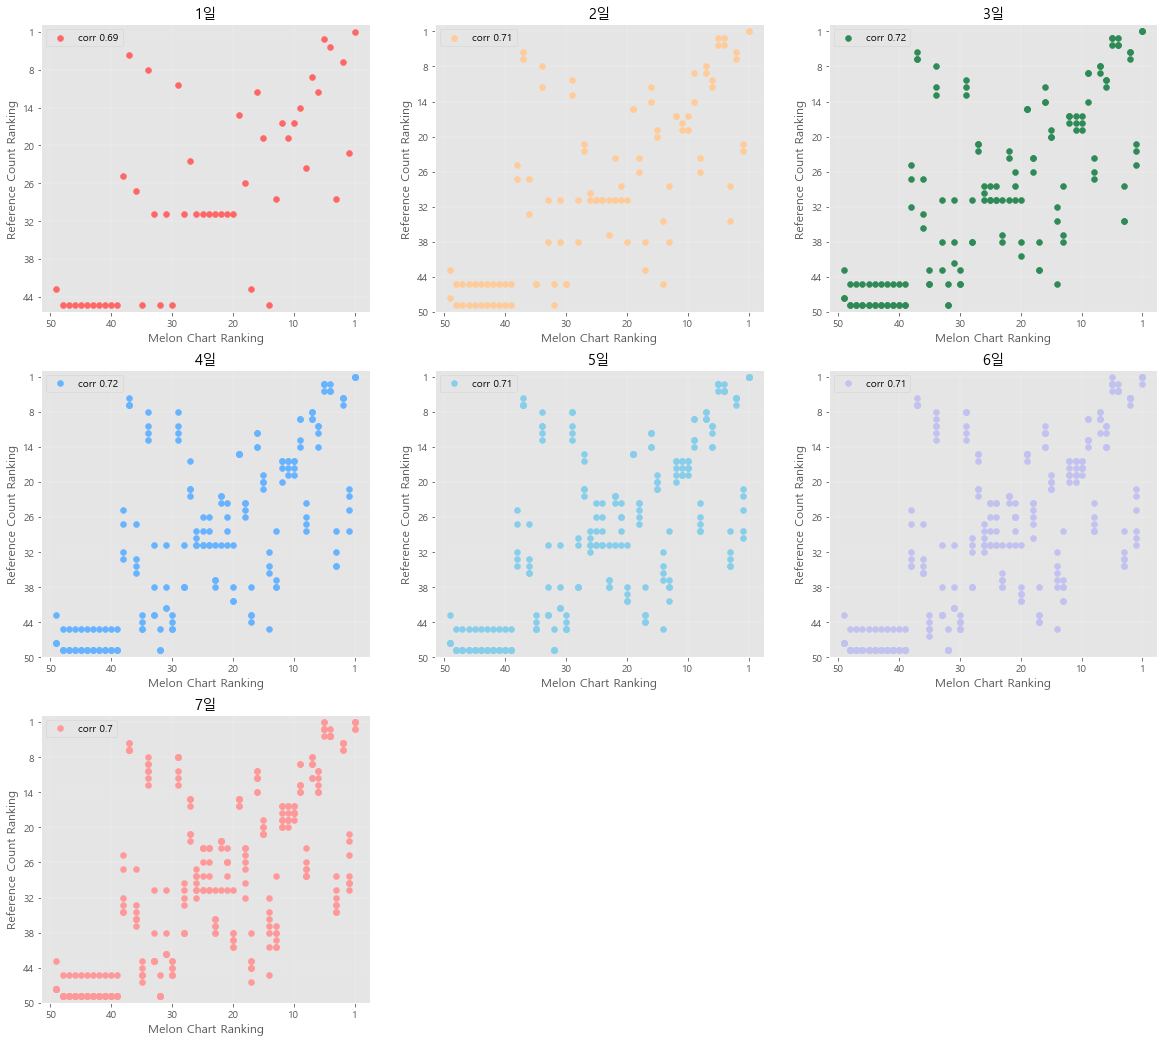

In [20]:
corr_draw()

아무래도 누적이다보니 그래프간의 상관도가 굉장히 높아보여서 seaborn을 이용하여 상관관계 시각화

[2019-12-09 21:49:01,916 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:01,946 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:01,986 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:02,023 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:02,065 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:02,106 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:02,140 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:02,174 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:02,213 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:02,259 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:02,297 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:02,333 _base.py:2515 - _update_title_position()] update_ti

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[2019-12-09 21:49:11,183 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:11,224 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:11,252 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:11,281 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:11,311 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:11,341 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:11,363 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:11,389 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:11,430 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:11,458 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:11,491 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:11,524 _base.py:2515 - _update_title_position()] update_ti

[2019-12-09 21:49:14,030 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:14,054 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:14,074 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:14,101 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:14,129 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:14,159 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:14,183 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:14,205 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:14,211 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:14,216 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:14,222 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:14,229 _base.py:2515 - _update_title_position()] update_ti

[2019-12-09 21:49:16,772 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:16,793 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:16,824 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:16,846 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:16,873 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:16,897 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:16,914 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:16,939 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:16,967 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:17,006 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:17,031 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:17,057 _base.py:2515 - _update_title_position()] update_ti

[2019-12-09 21:49:19,930 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:19,953 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:19,981 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:20,002 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:20,023 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:20,050 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:20,078 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:20,104 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:20,132 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:20,155 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:20,177 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:49:20,196 _base.py:2515 - _update_title_position()] update_ti

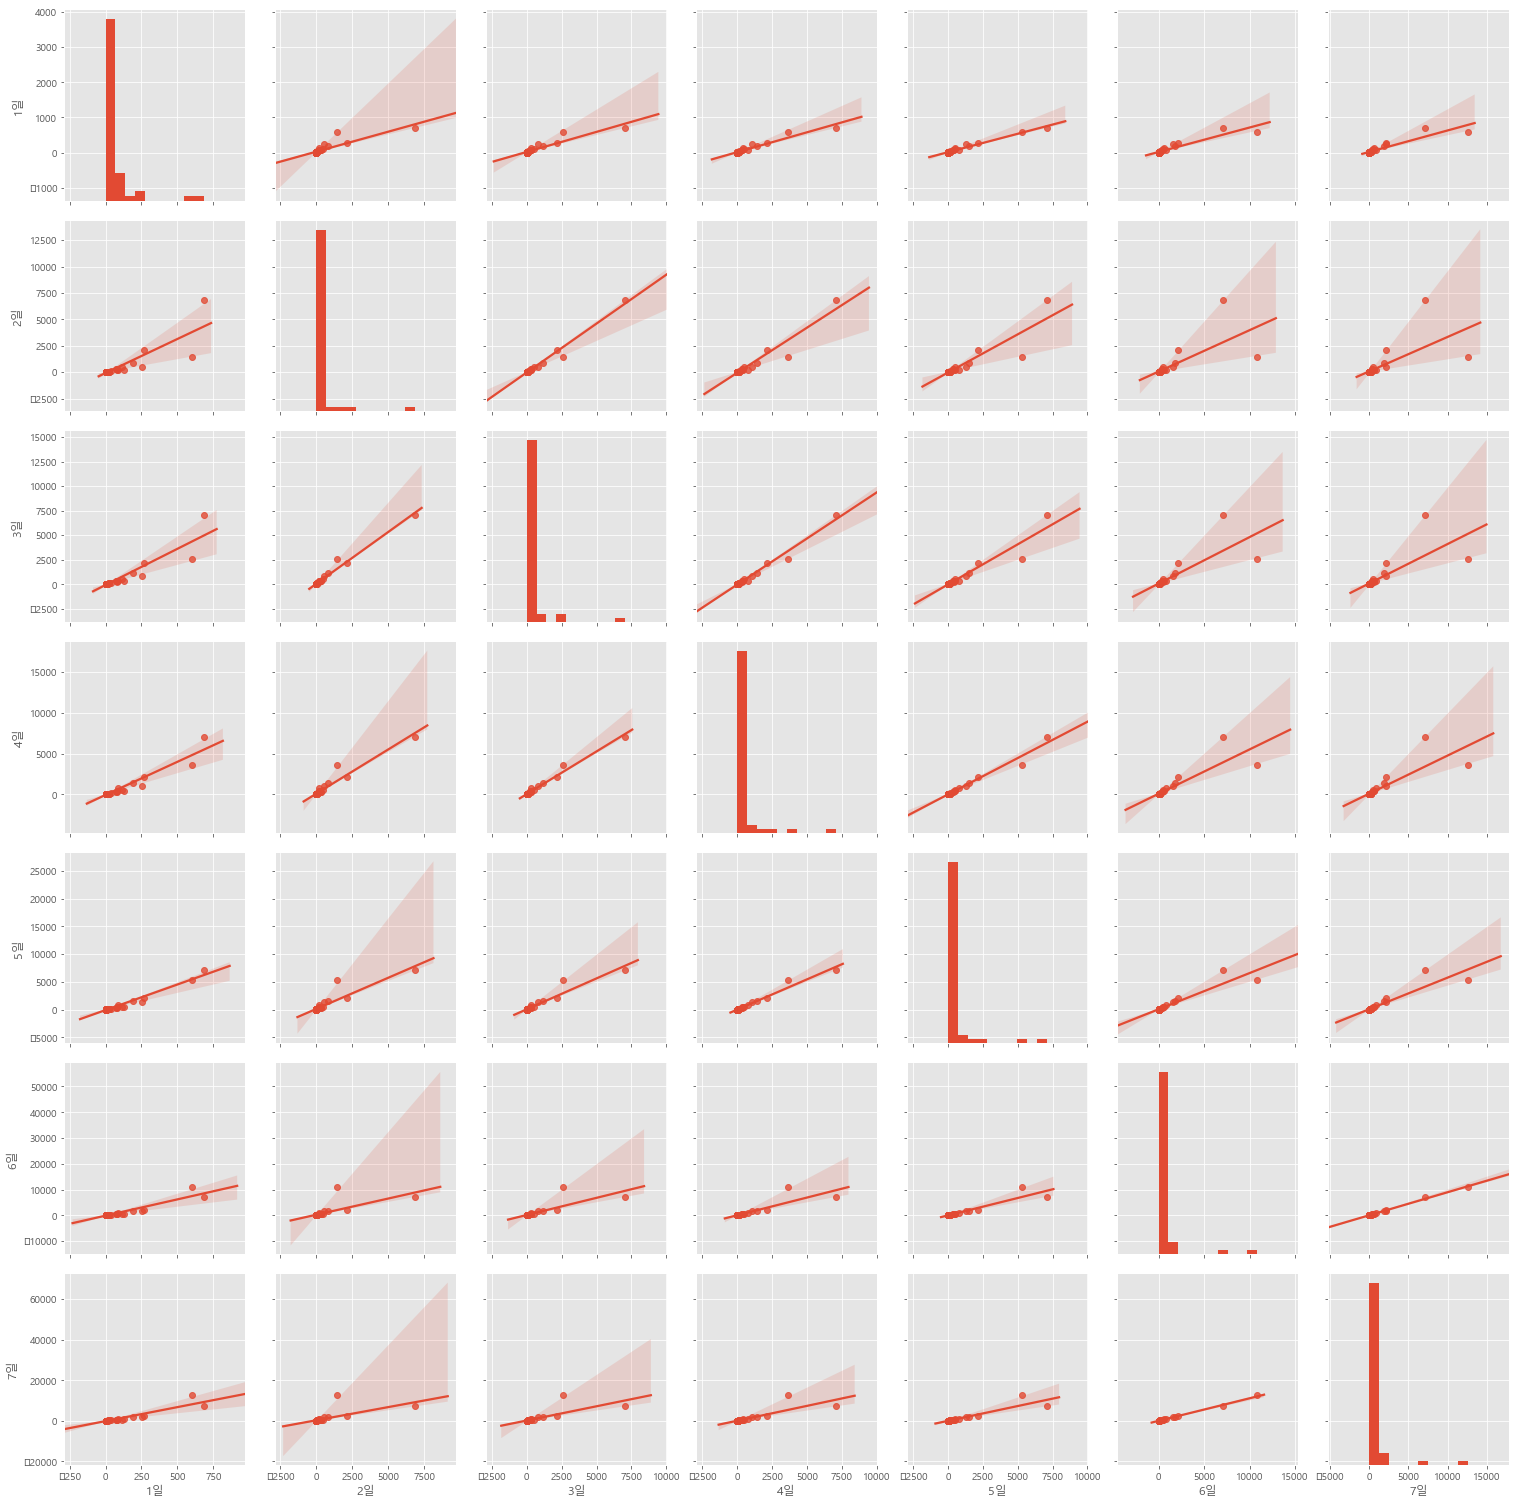

In [21]:
import seaborn as sns
columns = ['1일','2일','3일','4일','5일','6일','7일']
sns.pairplot(pd.read_csv(ANAL_PATH),vars=columns,kind="reg",height=3)
plt.savefig('a.png')
plt.show()

각 일별 상관관계가 양의 상관관계 (강한) 를 가지는 것을 볼 수 있다

## 4. 필터링

트위터 상에서 언급횟수를 받아왔지만 위 까지의 과정은 그저 언급 횟수를 카운팅만 하는 방식이였다  
이에 더 나아가 해당 곡명 + 가수에 대해 중복 아이디 제거 및 중복된 내용을 제거 했을 때에 대해서 분석

In [22]:
detail = pd.read_csv(DETAIL_PATH)
detail.head()

,melon_chart,song,singer,tweet_date,tweet_time,user_name,content,link,retweets,favorites,sing,facorites
0,1,Blueming,아이유,2019-11-19,23:56:23,tiramisu_1119,Blueming - 아이유 - 들어보세요. http://kko.to/dJ-GJ45j...,https://twitter.com/tiramisu_1119/status/11969...,0,NaN,NaN,0
1,1,Blueming,아이유,2019-11-19,23:55:29,_inthedesert516,Blueming - 아이유 - 들어보세요. http://kko.to/WzKvJ480...,https://twitter.com/_inthedesert516/status/119...,0,NaN,NaN,4
2,1,Blueming,아이유,2019-11-19,23:53:59,Dosiro,[MV] IU(아이유) _ Blueming(블루밍) https://youtu.be/...,https://twitter.com/Dosiro/status/119693971162...,0,NaN,NaN,0
3,1,Blueming,아이유,2019-11-19,23:48:14,dlwlrma0515,#아이유 #Blueming 뮤직비디오 인기 급상승 동영상 4위 https://you...,https://twitter.com/dlwlrma0515/status/1196938...,1,NaN,NaN,3
4,1,Blueming,아이유,2019-11-19,23:47:48,injeeel_,[MV] IU(아이유) _ Blueming(블루밍) https://youtu.be/...,https://twitter.com/injeeel_/status/1196938151...,0,NaN,NaN,1


### 아이디 중복 필터링

게시물 중복 제거에 앞서 각 곡마다 아이디에 대해 중복 제거를 하고 상관관계를 분석한다

중복 제거 전 아이디 갯수

In [23]:
len(detail['user_name'])

31472

중복 제거 후 아이디 갯수

In [24]:
detail = detail.drop_duplicates('user_name',keep='first')
len(detail['user_name'])

14146

50% 이상이 줄어든 것을 확인할 수 있다  
SNS상에서의 언급횟수에 동일한 ID로 광고성으로 많은 게시물을 남길 수 있으니, 동일한 ID일 경우 제거를 해서  
상관관계를 분석한다

In [25]:
detail = pd.read_csv(DETAIL_PATH)
songs = pd.read_csv(COMP_PATH)['song']
songs.head()

0             Blueming
1    늦은 밤 너의 집 앞 골목길에서
2            Love poem
3           이 번호로 전화해줘
4               시간의 바깥
Name: song, dtype: object

먼저 각 곡에 대해서 중복되는 아이디를 제거해야 하므로  
곡을 기준으로 demo_detail.csv 파일을 나눈다

In [26]:
split_by_song = list()

for i, song in enumerate(songs):
    split_by_song.append(detail[detail['song'] == song])
    
print("테스트 - 중복 제거 전 : ", len(split_by_song[0]))

테스트 - 중복 제거 전 :  7093


이제 ID를 기준으로 중복을 제거한다

In [27]:
counts = list()

for index, df in enumerate(split_by_song):
    split_by_song[index] = df.drop_duplicates('user_name', keep = 'first')
    counts.append(len(split_by_song[index]))
print("테스트 - 중복 제거 후 : ", len(split_by_song[0]))

테스트 - 중복 제거 후 :  3226


맨 첫번째 요소로 한정해서 보면, 7093 -> 3226으로 상당히 많이 줄어든 것을 볼 수 있다

* 중복 제거 전

In [28]:
compression = pd.read_csv('./data/demo_compression.csv')
compression.head()

,melon_chart,song,singer,count,start_date,end_date
0,1,Blueming,아이유,7093,2019-11-13 00:00:00,2019-11-20 00:00:00
1,2,늦은 밤 너의 집 앞 골목길에서,노을,71,2019-11-13 00:00:00,2019-11-20 00:00:00
2,3,Love poem,아이유,1864,2019-11-13 00:00:00,2019-11-20 00:00:00
3,4,이 번호로 전화해줘,바이브,69,2019-11-13 00:00:00,2019-11-20 00:00:00
4,5,시간의 바깥,아이유,2164,2019-11-13 00:00:00,2019-11-20 00:00:00


* 중복 제거 후

In [29]:
compression['count'] = counts
compression.head()

,melon_chart,song,singer,count,start_date,end_date
0,1,Blueming,아이유,3226,2019-11-13 00:00:00,2019-11-20 00:00:00
1,2,늦은 밤 너의 집 앞 골목길에서,노을,64,2019-11-13 00:00:00,2019-11-20 00:00:00
2,3,Love poem,아이유,834,2019-11-13 00:00:00,2019-11-20 00:00:00
3,4,이 번호로 전화해줘,바이브,58,2019-11-13 00:00:00,2019-11-20 00:00:00
4,5,시간의 바깥,아이유,1810,2019-11-13 00:00:00,2019-11-20 00:00:00


In [30]:
compression.to_csv('./data/rm_id_dup_compression.csv', index=False)

이제 중복 제거된 결과를 바탕으로 새로 데이터를 편집한다

In [31]:
rm_id_dup = split_by_song[0]
for i in range(1,50):
    rm_id_dup = pd.concat([rm_id_dup, split_by_song[i]], join = 'outer')

각 곡별로 중복되는 ID를 제거했으므로, 다시 원래 형식으로 합쳐주고  
rm_id_dup_detail.csv 라는 파일명으로 새로 저장한다

In [32]:
rm_id_dup.to_csv('./data/rm_id_dup_detail.csv', index = False)
pd.read_csv('./data/rm_id_dup_detail.csv').head()

,melon_chart,song,singer,tweet_date,tweet_time,user_name,content,link,retweets,favorites,sing,facorites
0,1,Blueming,아이유,2019-11-19,23:56:23,tiramisu_1119,Blueming - 아이유 - 들어보세요. http://kko.to/dJ-GJ45j...,https://twitter.com/tiramisu_1119/status/11969...,0,NaN,NaN,0
1,1,Blueming,아이유,2019-11-19,23:55:29,_inthedesert516,Blueming - 아이유 - 들어보세요. http://kko.to/WzKvJ480...,https://twitter.com/_inthedesert516/status/119...,0,NaN,NaN,4
2,1,Blueming,아이유,2019-11-19,23:53:59,Dosiro,[MV] IU(아이유) _ Blueming(블루밍) https://youtu.be/...,https://twitter.com/Dosiro/status/119693971162...,0,NaN,NaN,0
3,1,Blueming,아이유,2019-11-19,23:48:14,dlwlrma0515,#아이유 #Blueming 뮤직비디오 인기 급상승 동영상 4위 https://you...,https://twitter.com/dlwlrma0515/status/1196938...,1,NaN,NaN,3
4,1,Blueming,아이유,2019-11-19,23:47:48,injeeel_,[MV] IU(아이유) _ Blueming(블루밍) https://youtu.be/...,https://twitter.com/injeeel_/status/1196938151...,0,NaN,NaN,1


위의 내용을 바탕으로 앞에서 한 데이터 분석을 한다  

In [33]:
ANAL_PATH = './data/analysis_rm_id_dup.csv'
DETAIL_PATH = './data/rm_id_dup_detail.csv'
COMP_PATH = './data/rm_id_dup_compression.csv'

analysis_csv_init()
pd.read_csv(ANAL_PATH).head()

,song,singer,1일,2일,3일,4일,5일,6일,7일
0,Blueming,아이유,0,0,0,0,0,0,0
1,늦은 밤 너의 집 앞 골목길에서,노을,0,0,0,0,0,0,0
2,Love poem,아이유,0,0,0,0,0,0,0
3,이 번호로 전화해줘,바이브,0,0,0,0,0,0,0
4,시간의 바깥,아이유,0,0,0,0,0,0,0


앞에서 미리 정의해둔 함수들을 이용한다  

In [34]:
analysis_to_csv(end_date)
pd.read_csv(ANAL_PATH).head()

,song,singer,1일,2일,3일,4일,5일,6일,7일
0,Blueming,아이유,522,3165,3217,3218,3220,3226,3226
1,늦은 밤 너의 집 앞 골목길에서,노을,20,30,38,42,45,52,64
2,Love poem,아이유,130,555,649,711,752,804,834
3,이 번호로 전화해줘,바이브,3,6,13,20,31,44,58
4,시간의 바깥,아이유,216,1791,1794,1799,1802,1807,1810


[2019-12-09 21:50:40,366 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:40,414 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:40,457 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:40,494 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:40,537 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:40,577 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:40,619 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:40,689 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:40,731 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:40,772 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:40,806 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:40,847 _base.py:2515 - _update_title_position()] update_ti

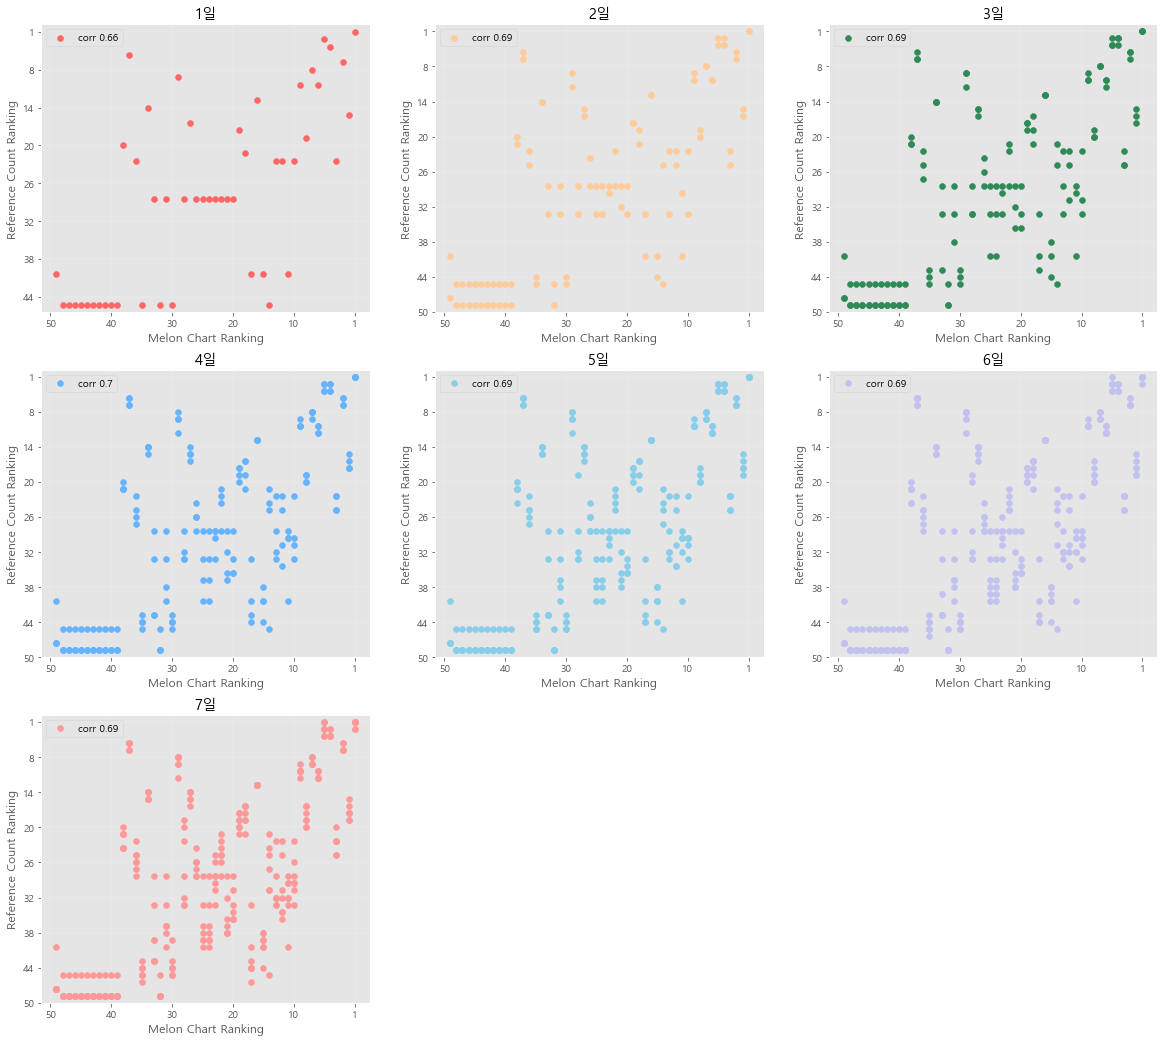

In [35]:
corr_draw()

### 게시물 내용 중복 필터링

이제 광고성 글들을 덜어내기 위해 중복되는 게시물 내용을 없애고 상관관계를 분석한다

In [36]:
detail = pd.read_csv('./data/demo_detail.csv')
len(detail['content'])

31472

In [37]:
detail = detail.drop_duplicates('content', keep='first')
len(detail['content'])

23872

전체 31472개의 게시물 중 게시물 내용이 중복되는 (content column) 것들을 제거했더니 23872개로 줄어든 것을 확인할 수 있다  
그럼 앞에서 한 아이디 중복 제거와 같은 과정을 거쳐서 게시물 중복 제거를 한 뒤에 상관관계를 분석한다

In [38]:
DETAIL_PATH = './data/demo_detail.csv'
COMP_PATH = './data/demo_compression.csv'

detail = pd.read_csv(DETAIL_PATH)
song = pd.read_csv(COMP_PATH)['song']
song.head()

0             Blueming
1    늦은 밤 너의 집 앞 골목길에서
2            Love poem
3           이 번호로 전화해줘
4               시간의 바깥
Name: song, dtype: object

In [39]:
split_by_song = list()

for i, song in enumerate(songs):
    split_by_song.append(detail[detail['song'] == song])
    
print("테스트 - 중복 제거 전 : ", len(split_by_song[0]))

테스트 - 중복 제거 전 :  7093


In [40]:
counts = list()

for index, df in enumerate(split_by_song):
    split_by_song[index] = df.drop_duplicates('content', keep = 'first')
    counts.append(len(split_by_song[index]))
print("테스트 - 중복 제거 후 : ", len(split_by_song[0]))

테스트 - 중복 제거 후 :  5994


* 중복 제거 전

In [41]:
compression = pd.read_csv('./data/demo_compression.csv')
compression.head()

,melon_chart,song,singer,count,start_date,end_date
0,1,Blueming,아이유,7093,2019-11-13 00:00:00,2019-11-20 00:00:00
1,2,늦은 밤 너의 집 앞 골목길에서,노을,71,2019-11-13 00:00:00,2019-11-20 00:00:00
2,3,Love poem,아이유,1864,2019-11-13 00:00:00,2019-11-20 00:00:00
3,4,이 번호로 전화해줘,바이브,69,2019-11-13 00:00:00,2019-11-20 00:00:00
4,5,시간의 바깥,아이유,2164,2019-11-13 00:00:00,2019-11-20 00:00:00


* 중복 제거 후

In [42]:
compression['count'] = counts
compression.head()

,melon_chart,song,singer,count,start_date,end_date
0,1,Blueming,아이유,5994,2019-11-13 00:00:00,2019-11-20 00:00:00
1,2,늦은 밤 너의 집 앞 골목길에서,노을,67,2019-11-13 00:00:00,2019-11-20 00:00:00
2,3,Love poem,아이유,1806,2019-11-13 00:00:00,2019-11-20 00:00:00
3,4,이 번호로 전화해줘,바이브,66,2019-11-13 00:00:00,2019-11-20 00:00:00
4,5,시간의 바깥,아이유,1351,2019-11-13 00:00:00,2019-11-20 00:00:00


content의 중복 제거를 한 언급 횟수로 업데이트를 해서 새로운 csv 파일로 저장한다

In [43]:
compression.to_csv('./data/rm_content_dup_compression.csv', index=False)

In [44]:
rm_content_dup = split_by_song[0]
for i in range(1,50):
    rm_content_dup = pd.concat([rm_content_dup, split_by_song[i]], join = 'outer')

In [45]:
rm_content_dup.to_csv('./data/rm_content_dup_detail.csv', index = False)
pd.read_csv('./data/rm_content_dup_detail.csv').head()

,melon_chart,song,singer,tweet_date,tweet_time,user_name,content,link,retweets,favorites,sing,facorites
0,1,Blueming,아이유,2019-11-19,23:56:23,tiramisu_1119,Blueming - 아이유 - 들어보세요. http://kko.to/dJ-GJ45j...,https://twitter.com/tiramisu_1119/status/11969...,0,NaN,NaN,0
1,1,Blueming,아이유,2019-11-19,23:55:29,_inthedesert516,Blueming - 아이유 - 들어보세요. http://kko.to/WzKvJ480...,https://twitter.com/_inthedesert516/status/119...,0,NaN,NaN,4
2,1,Blueming,아이유,2019-11-19,23:53:59,Dosiro,[MV] IU(아이유) _ Blueming(블루밍) https://youtu.be/...,https://twitter.com/Dosiro/status/119693971162...,0,NaN,NaN,0
3,1,Blueming,아이유,2019-11-19,23:48:14,dlwlrma0515,#아이유 #Blueming 뮤직비디오 인기 급상승 동영상 4위 https://you...,https://twitter.com/dlwlrma0515/status/1196938...,1,NaN,NaN,3
4,1,Blueming,아이유,2019-11-19,23:47:48,injeeel_,[MV] IU(아이유) _ Blueming(블루밍) https://youtu.be/...,https://twitter.com/injeeel_/status/1196938151...,0,NaN,NaN,1


In [46]:
ANAL_PATH = './data/analysis_rm_content_dup.csv'
DETAIL_PATH = './data/rm_content_dup_detail.csv'
COMP_PATH = './data/rm_content_dup_compression.csv'

analysis_csv_init()
pd.read_csv(ANAL_PATH).head()

,song,singer,1일,2일,3일,4일,5일,6일,7일
0,Blueming,아이유,0,0,0,0,0,0,0
1,늦은 밤 너의 집 앞 골목길에서,노을,0,0,0,0,0,0,0
2,Love poem,아이유,0,0,0,0,0,0,0
3,이 번호로 전화해줘,바이브,0,0,0,0,0,0,0
4,시간의 바깥,아이유,0,0,0,0,0,0,0


In [47]:
analysis_to_csv(end_date)
pd.read_csv(ANAL_PATH).head()

,song,singer,1일,2일,3일,4일,5일,6일,7일
0,Blueming,아이유,545,5786,5965,5966,5971,5994,5994
1,늦은 밤 너의 집 앞 골목길에서,노을,18,29,37,42,46,52,67
2,Love poem,아이유,192,818,1140,1391,1499,1720,1806
3,이 번호로 전화해줘,바이브,3,6,13,22,33,49,66
4,시간의 바깥,아이유,224,1318,1329,1336,1341,1348,1351


[2019-12-09 21:50:55,254 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:55,317 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:55,370 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:55,416 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:55,457 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:55,511 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:55,569 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:55,655 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:55,699 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:55,741 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:55,796 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:50:55,844 _base.py:2515 - _update_title_position()] update_ti

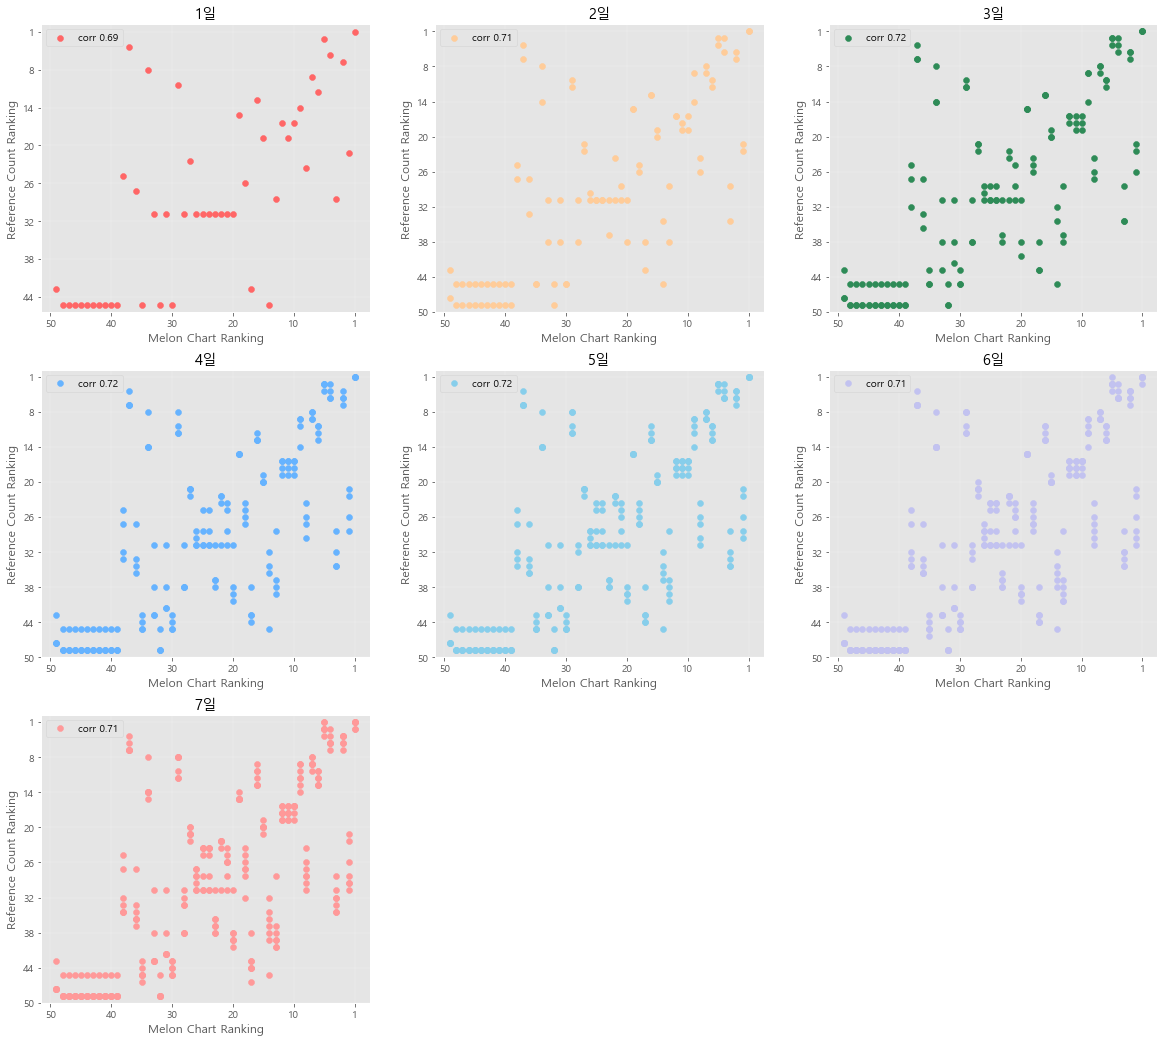

In [48]:
corr_draw()

## 5. 중복 데이터 분석

ID 중복을 제거한 경우는 31472 -> 14146 으로,  
게시물 내용 중복을 제거한 경우는 31472 -> 23872로  
상당수의 중복된 ID or 게시물 내용이 검출되었다   
  
이에 대해 어떤 곡이, 어떤 가수가 중복되는 ID or 게시물 내용이 검출되었는지에 대해 분석한다

In [49]:
before_rm = pd.read_csv('./data/demo_compression.csv')  # 중복 제거 전
after_rm_id = pd.read_csv('./data/rm_id_dup_compression.csv')  # id 중복 제거 전
after_rm_cont = pd.read_csv('./data/rm_content_dup_compression.csv')  # content 중복 제거 전

중복 제거 전, 중복 제거 후의 데이터들을 DataFrame 타입으로 저장한다

In [50]:
songs = before_rm['song']
singers = before_rm['singer']
before_rm_count = before_rm['count']
before_rm_id_count = after_rm_id['count']
before_rm_cont_count = after_rm_cont['count']

id_dup_count = before_rm_count  - before_rm_id_count
cont_dup_count = before_rm_count - before_rm_cont_count

각 DataFrame에서 'count' 컬럼만을 뽑아서 id, content의 중복되는 개수를 Element-wise 연산을 한다

In [51]:
id_dup_ratio = id_dup_count / before_rm_count
cont_dup_ratio = cont_dup_count / before_rm_count

그냥 개수로만 판단한다면 아무래도 언급횟수가 많은 가수들이 중복되는 게시물도 많을 것이기 때문에  
이를 고려해서 전체 언급횟수로 나눠줘서 비율로 판단한다

In [52]:
id_dup_ratio, id_dup_rank_song, id_dup_rank_singer = zip(*sorted(zip(id_dup_ratio, songs, singers), reverse = True))

In [53]:
print("# ID 중복 Top 3\n")
for i in range(3):
    print("Rank"+str(i+1) + "  :  " + str(id_dup_rank_song[i]) + " - " + str(id_dup_rank_singer[i]))

# ID 중복 Top 3

Rank1  :  있어줘요 - 장덕철
Rank2  :  샤넬  - MC몽
Rank3  :  LION - nan


In [54]:
cont_dup_ratio, cont_dup_rank_song, cont_dup_rank_singer = zip(*sorted(zip(cont_dup_ratio, songs, singers), reverse = True))

In [55]:
print("# 게시물 중복 Top 3\n")
for i in range(3):
    print("Rank"+str(i+1) + "  :  " + str(cont_dup_rank_song[i]) + " - " + str(cont_dup_rank_singer[i]))

# 게시물 중복 Top 3

Rank1  :  다시 만날까 봐 - V.O.S
Rank2  :  우리 어떻게 할까요 - 첸 
Rank3  :  시간의 바깥 - 아이유


## 6. 중복 데이터 순위 - 멜론 차트 순위 상관관계 분석

중복 ID & 게시물 갯수와 멜론 차트순위의 상관관계를 분석한다  
중복 ID 혹은 게시물 비율이 높다는 것은 광고성 게시물이 많다는 것으로 가정한다면,  
SNS 상에서의 광고가 실제 멜론 차트와 어떤 상관관계가 있는지에 대해서 알아볼 수 있다

In [56]:
def corr_draw2(title, duplicated):
    melon_chart = np.array(pd.read_csv('./data/demo_compression.csv')['song'])
    melon_score = list()
    dup_score = list()
    yticks = [50, 44, 38, 32, 26 , 20, 14, 8, 1]
    xticks = [0,50, 40, 30, 20 , 10, 1]
    fig = plt.figure(figsize=(8,6))

    for i, song in enumerate(melon_chart):
        # 중복 갯수로 정렬한 점수
        dup_score.append(50 - duplicated.index(song))   
        # 멜론 차트 랭킹 점수
        melon_score.append(51 - i)

    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.scatter(melon_score, dup_score, label='corr ' + str(round(np.corrcoef(melon_score, dup_score)[0][1], 2)))
    ax.legend(fontsize='medium', loc='upper left')
    ax.set_xlabel('Melon Chart Ranking')
    ax.set_ylabel('Duplicated Ratio Ranking')
    ax.set_ylim([min(dup_score)-1, max(dup_score)+1])
    ax.set_xticklabels(xticks)
    ax.set_yticklabels(yticks)
    ax.grid(linewidth=0.2)

중복 ID와 멜론 차트간의 상관관계를 시각화한다

[2019-12-09 21:51:15,222 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:51:15,272 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:51:15,342 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:51:15,381 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:51:15,404 _base.py:2515 - _update_title_position()] update_title_pos


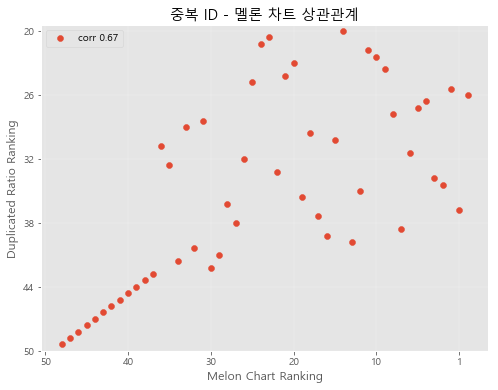

In [59]:
corr_draw2(title = "중복 ID - 멜론 차트 상관관계", duplicated = id_dup_rank_song)

[2019-12-09 21:51:19,798 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:51:19,846 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:51:19,915 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:51:19,956 _base.py:2515 - _update_title_position()] update_title_pos
[2019-12-09 21:51:19,982 _base.py:2515 - _update_title_position()] update_title_pos


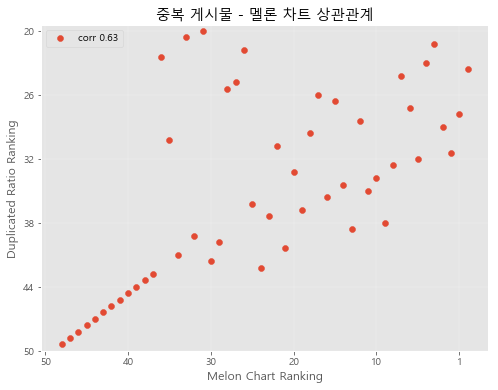

In [60]:
corr_draw2(title = "중복 게시물 - 멜론 차트 상관관계", duplicated = cont_dup_rank_song)

이렇게 중복 ID, 게시물 비율이 높은 곡들도 멜론 차트와 강한 상관관계가 있음을 확인할 수 있다  
중복된 ID와 게시물들을 광고성이라고 가정하면, 광고성이 있는 게시물들의 비율과 멜론차트는 상관관계가 있다고 볼 수 있다